In [1]:
import argparse
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
from torch import nn
from torch.utils.data import TensorDataset, DataLoader
import math
from model import *
from utils import *

In [2]:
parser = argparse.ArgumentParser('Proyecto_8091', add_help=False)
parser.add_argument('--data_folder', default='./data', type=str, help='Folder path to dataset')
parser.add_argument('--magnetometry_folder', default='Datos_Magnetometria_Anomalia_Magnetica_de_Campo_Total', type=str, help='Folder path to magnetometry data')
args = parser.parse_args(args=[])

# load data
magnetometry_path = os.path.join(args.data_folder, args.magnetometry_folder, "Puntos_Grilla_Anomalia_Magnetica_de_Campo_Total_SGC.xlsx")

df_magnetometry = pd.read_excel(magnetometry_path)

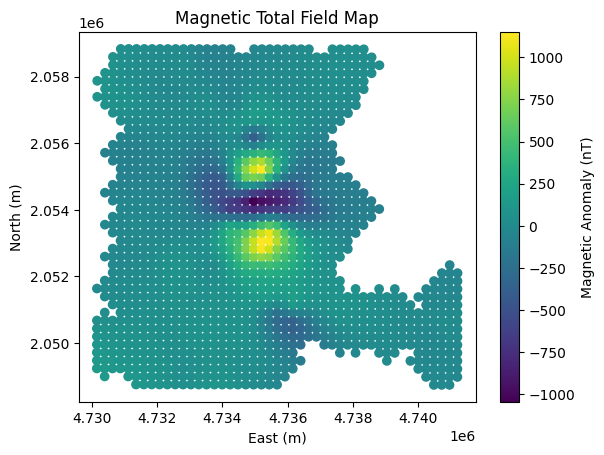

In [3]:
# Scatter plot of magnetic anomaly
plt.scatter(df_magnetometry["Este"], df_magnetometry["Norte"], c=df_magnetometry["Anomalia_Magnetica_Campo_Total"], cmap="viridis")
plt.colorbar(label="Magnetic Anomaly (nT)")
plt.xlabel("East (m)")
plt.ylabel("North (m)")
plt.title("Magnetic Total Field Map")
plt.show()

In [4]:
# Coordinates and values
x_magn = df_magnetometry["Este"].values
y_magn = df_magnetometry["Norte"].values
z_magn = df_magnetometry["Anomalia_Magnetica_Campo_Total"].values

grid_x_magn1, grid_y_magn1 = np.mgrid[x_magn.min():x_magn.max():200j, y_magn.min():y_magn.max():200j]

In [5]:
# numpy matrix
coords_magn = np.stack([x_magn, y_magn], axis=1).astype(np.float32)   # [M, 2]
targets_magn = z_magn.astype(np.float32).reshape(-1, 1)               # [M, 1]

coords_magn_min = np.stack([np.min(x_magn), np.min(y_magn)], axis=0).astype(np.float32) 
coords_magn_max = np.stack([np.max(x_magn), np.max(y_magn)], axis=0).astype(np.float32)

targets_magn_max = np.max(targets_magn)   
targets_magn_min = np.min(targets_magn)   


Xm_n = (coords_magn[:,0]-coords_magn_min[0])/(coords_magn_max[0]-coords_magn_min[0])
Ym_n = (coords_magn[:,1]-coords_magn_min[1])/(coords_magn_max[1]-coords_magn_min[1])


coords_magn_norm = np.stack([Xm_n, Ym_n], axis=1).astype(np.float32)

# DataLoaders
ds_magn = TensorDataset(torch.from_numpy(coords_magn_norm), torch.from_numpy(targets_magn))

dl_magn = DataLoader(ds_magn, batch_size=256, shuffle=True)

In [6]:
#Split dataloader
batch_size = 256
train_magn, val_magn = train_val_split(ds_magn, val_ratio=0.2)

dl_magn_train = DataLoader(train_magn, batch_size=batch_size, shuffle=True, num_workers=0)
dl_magn_val   = DataLoader(val_magn,   batch_size=batch_size, shuffle=False, num_workers=0)


In [9]:
###### Training

iter = 10
activation = "wire"
input_transform = "FF"
num_layers = 15
num_neurons = 128

epochs = 5000

lr = 1e-4
max_lr = 2e-4

optimizer = torch.optim.Adam(model.parameters(), lr=lr)
criterion = nn.MSELoss()
scheduler = torch.optim.lr_scheduler.OneCycleLR(
    optimizer,
    max_lr=max_lr,
    steps_per_epoch=len(train_magn),
    epochs=epochs
)

In [ ]:
for i in range(2,iter+1):
    if activation == "wire":
        model = CMLP(
            in_features=2, out_features=1,
            hidden_layers=num_layers, hidden_units=num_neurons,
            activation=activation, wire_omega=1.0, wire_sigma=1.0, input_transform=input_transform  # synthetic-like defaults
        )

    if activation == "sine":
        model = CMLP(
            in_features=2, out_features=1,
            hidden_layers=num_layers, hidden_units=num_neurons,
            activation=activation, sine_w0=1.0, input_transform=input_transform  # synthetic-like defaults
        )

    if activation == "relu":
        model = CMLP(
            in_features=2, out_features=1,
            hidden_layers=num_layers, hidden_units=num_neurons,
            activation=activation, input_transform=input_transform  # synthetic-like defaults
        )


    loss = []
    for epoch in range(epochs):
        for batch_magn in dl_magn_train:
            optimizer.zero_grad()
            coords_magn, target_magn = batch_magn
            pred_magn = model(coords_magn)
            pred_magn_denorm = denorm_torch(pred_magn, targets_magn_min, targets_magn_max)

            loss = criterion(pred_magn_denorm,target_magn)
            loss.backward()
            optimizer.step()
            scheduler.step()

        if (epoch + 1) % 100 == 0:
            torch.save(model.state_dict(), f'checkpoints/{i}magn_model_{epochs}_{activation}_{lr}_{max_lr}_{input_transform}.pth')

        print("Iter: ", i," Epoch: ", epoch, " Loss: ", loss.item())

Iter:  2  Epoch:  0  Loss:  7025269.5
Iter:  2  Epoch:  1  Loss:  5667330.0
Iter:  2  Epoch:  2  Loss:  4560526.5
Iter:  2  Epoch:  3  Loss:  3488872.0
Iter:  2  Epoch:  4  Loss:  2608268.5
Iter:  2  Epoch:  5  Loss:  1927911.75
Iter:  2  Epoch:  6  Loss:  1485840.625
Iter:  2  Epoch:  7  Loss:  1036786.625
Iter:  2  Epoch:  8  Loss:  709809.5
Iter:  2  Epoch:  9  Loss:  438593.5
Iter:  2  Epoch:  10  Loss:  314086.6875
Iter:  2  Epoch:  11  Loss:  195806.875
Iter:  2  Epoch:  12  Loss:  109830.9921875
Iter:  2  Epoch:  13  Loss:  83461.15625
Iter:  2  Epoch:  14  Loss:  41912.859375
Iter:  2  Epoch:  15  Loss:  58250.26953125
Iter:  2  Epoch:  16  Loss:  47639.76171875
Iter:  2  Epoch:  17  Loss:  39065.25
Iter:  2  Epoch:  18  Loss:  66250.8671875
Iter:  2  Epoch:  19  Loss:  61440.26953125
Iter:  2  Epoch:  20  Loss:  61978.62109375
Iter:  2  Epoch:  21  Loss:  64463.0078125
Iter:  2  Epoch:  22  Loss:  48752.88671875
Iter:  2  Epoch:  23  Loss:  57694.140625
Iter:  2  Epoch:  24  L

In [10]:
activation = "wire"

for i in range(iter+1):

    if activation == "wire":
        model = CMLP(
            in_features=2, out_features=1,
            hidden_layers=num_layers, hidden_units=num_neurons,
            activation=activation, wire_omega=1.0, wire_sigma=1.0, input_transform=input_transform  # synthetic-like defaults
        )

    if activation == "sine":
        model = CMLP(
            in_features=2, out_features=1,
            hidden_layers=num_layers, hidden_units=num_neurons,
            activation=activation, sine_w0=1.0, input_transform=input_transform  # synthetic-like defaults
        )

    if activation == "relu":
        model = CMLP(
            in_features=2, out_features=1,
            hidden_layers=num_layers, hidden_units=num_neurons,
            activation=activation, input_transform=input_transform  # synthetic-like defaults        
        )
    model.load_state_dict(torch.load(f"checkpoints/{1}magn_model_{epochs}_{activation}_{lr}_{max_lr}_{input_transform}.pth", weights_only=True))
    model.eval()

    mse = []
    for batch_magn in dl_magn_val:
        coords_magn, target_magn = batch_magn

        pred_magn = model(coords_magn)
        pred_magn_denorm = denorm_torch(pred_magn, targets_magn_min, targets_magn_max)

        coords_magn_denorm = denorm_torch(coords_magn, coords_magn_min, coords_magn_max)

        #print("Coords: ", coords_magn_denorm[0], " Target: ", target_magn[2].item(), " Prediction: ", pred_magn_denorm[2].item())
        #print("MSE: ", criterion(pred_magn_denorm,target_magn).item())

        mse.append(criterion(pred_magn_denorm,target_magn).item())


print("MSE Mean: ", np.mean(mse))

MSE Mean:  481.4898986816406


In [ ]:
######  agregar code inferencia

#### Relu
###MSE: 


#### Sine
###MSE:  432.54088592529297

#### Wire
###MSE:  481.4898986816406